In [1]:
import os
import sys
import random
import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
import aup
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json("../scripts/Metropolis_CVE.json")

In [3]:
city = 'Guadalajara'
df[city]

mpos    [14002, 14039, 14044, 14051, 14070, 14097, 140...
edo                                                  [14]
Name: Guadalajara, dtype: object

In [4]:
def load_network_data(city):
    mpos_folder = 'mpos_2020'
    # Creates empty GeoDataFrame to store specified municipality polygons
    mun_gdf = gpd.GeoDataFrame()
    #ageb_gdf = gpd.GeoDataFrame()
    hex_bins = gpd.GeoDataFrame()
    # Iterates over municipality codes for each metropolitan area or capital
    for i in range(len(df.loc["mpos", city])):
        # Extracts specific municipality code
        m = df.loc["mpos", city][i]
        # Downloads municipality polygon according to code
        query = f"SELECT * FROM marco.{mpos_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
        mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))

        #Creates query to download hex bins
        query = f"SELECT * FROM hexgrid.hex_grid WHERE \"CVEGEO\" LIKE \'{m}%%\'"
        hex_bins = hex_bins.append(aup.gdf_from_query(query, geometry_col='geometry'))


    #Define projections
    mun_gdf = mun_gdf.set_crs("EPSG:4326")
    hex_bins = hex_bins.set_crs("EPSG:4326")
    mun_gdf = mun_gdf.dissolve(by='CVE_ENT')
    G = ox.graph_from_polygon(mun_gdf['geometry'][0], network_type='all_private', retain_all=True)
    return mun_gdf, hex_bins, G

In [5]:
mun_gdf, hex_bins, G = load_network_data(city)

In [6]:
nodes, edges = ox.graph_to_gdfs(G)

In [7]:
def calculate_distance_nearest_poi(gdf_f, nodes, edges, amenity_name, column_name):
	"""
	Calculate the distance to the shortest path to the nearest POI (in gdf_f) for all the nodes in the network G

	Arguments:
		gdf_f {geopandas.GeoDataFrame} -- GeoDataFrame with the Points of Interest the geometry type has to be shapely.Point
		G {networkx.MultiDiGraph} -- Graph created with OSMnx
		amenity_name {str} -- string with the name of the amenity that is used as seed (pharmacy, hospital, shop, etc.) 
		city {str} -- string with the name of the city

	Returns:
		geopandas.GeoDataFrame -- GeoDataFrame with geometry and distance to the nearest POI
	"""
	nodes = nodes.copy()
	edges = edges.copy()
	gdf_f = gdf_f.loc[gdf_f.distance_node<=500]
	g, weights, node_mapping = aup.to_igraph(nodes,edges) #convert to igraph to run the calculations
	col_dist = f'dist_{amenity_name}'
	seeds = aup.get_seeds(gdf_f, node_mapping, column_name)
	voronoi_assignment = aup.voronoi_cpu(g, weights, seeds)
	distances = aup.get_distances(g,seeds,weights,voronoi_assignment)

	nodes[col_dist] = distances

	return nodes

In [8]:
choices = [random.choices(hex_bins['hex_id_8'].to_list(),k=i) for i in [50,350]]

In [9]:
hex_bins['centroid'] = hex_bins.centroid

<ipython-input-9-6ed97238536a>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hex_bins['centroid'] = hex_bins.centroid


In [10]:
d = {'location_name': ['name1'], 'geometry': [Point(-103.345789,20.677739)]}
gdf_point = gpd.GeoDataFrame(d,crs="EPSG:4326")

for i, name in zip([0,1],['name2','name3']):
    temp = hex_bins[hex_bins['hex_id_8'].isin(choices[i])]
    temp.set_geometry('centroid',inplace=True)
    gdf_point = gdf_point.append(gpd.GeoDataFrame({'location_name':[f'{name}']*len(temp),'geometry':temp['centroid']},crs="EPSG:4326"))

/Users/natera/miniconda3/envs/ox/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [11]:
nodes_ = []
distances_ = []
for _, row in gdf_point.iterrows():
    node, distance = ox.get_nearest_node(G, (row.geometry.y,row.geometry.x), return_dist=True)
    nodes_.append(node)
    distances_.append(distance)
gdf_point['osmid'] = nodes_
gdf_point['distance_node'] = distances_

In [12]:
nodes_distances = [calculate_distance_nearest_poi(gdf_point[gdf_point['location_name'] == f'name{i}'], nodes, edges, f'dist_name{i}', 'osmid') for i in range(1,4)]

In [13]:
hex_bins = hex_bins.set_crs("EPSG:4326")
hex_bins_all = []
for nodes_distance, i in zip(nodes_distances, range(1,4)):
    nodes_distance.reset_index(inplace=True)
    nodes_distance = nodes_distance.set_crs("EPSG:4326")
    hex_dist = aup.group_by_hex_mean(nodes_distance, hex_bins, 8, f'dist_name{i}')
    hex_bins_ = hex_bins.merge(hex_dist[['hex_id_'+str(8),f'dist_dist_name{i}']], on='hex_id_'+str(8))
    hex_bins_all.append(hex_bins_)

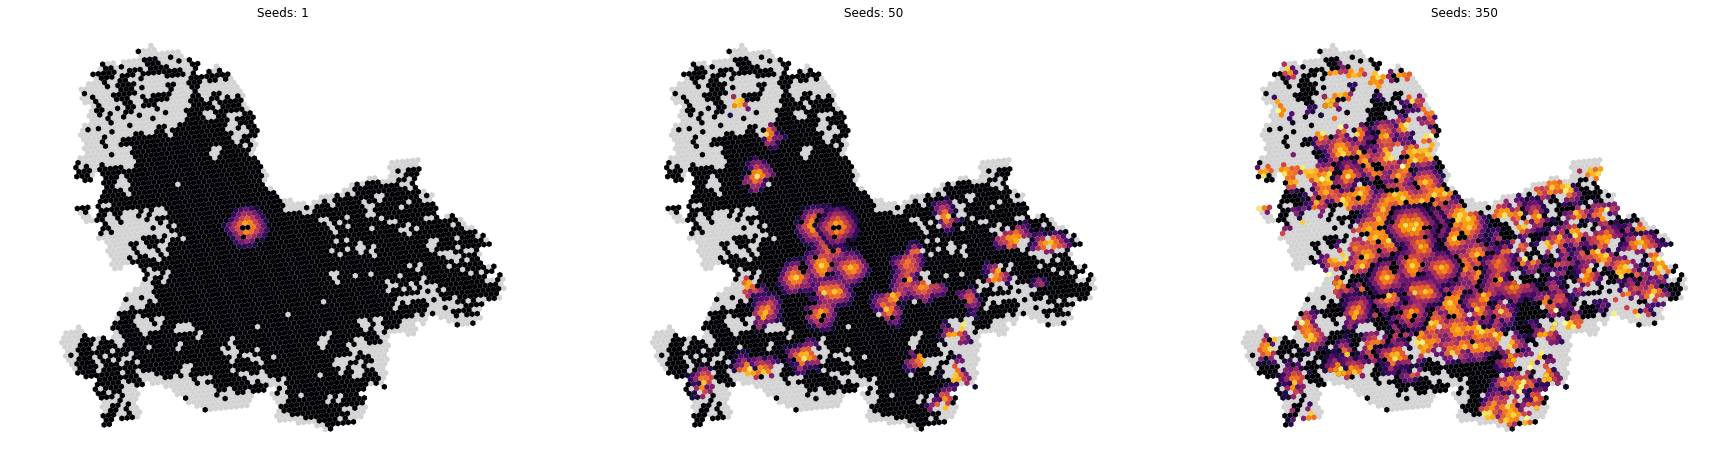

In [14]:
vmax = 2500
fig, axes = plt.subplots(1,3,figsize=(30,20))
for hex_bins, i, ax, seeds in zip(hex_bins_all, range(1,4), axes.flat, [1,50,350]):
    hex_bins.plot(color='lightgrey', ax=ax, zorder=0)
    if i == 1:
        hex_bins[hex_bins[f'dist_dist_name{i}']>0].plot(column=f'dist_dist_name{i}', ax=ax, cmap = "inferno_r", zorder=1, vmin=0,vmax=vmax)
        #gdf_point[gdf_point['location_name']==f'name{i}'].plot(color='red',markersize=10,ax=ax, zorder=2)
    elif i == 2:
        hex_bins_all[0][(hex_bins_all[0]['dist_dist_name1']>0) & (hex_bins_all[0]['dist_dist_name1']<vmax)].plot(column=f'dist_dist_name1', ax=ax, cmap = "inferno_r", zorder=2, vmin=0,vmax=vmax)
        hex_bins[hex_bins[f'dist_dist_name{i}']>0].plot(column=f'dist_dist_name{i}', ax=ax, cmap = "inferno_r", zorder=1, vmin=0,vmax=vmax)
        #gdf_point[(gdf_point['location_name']==f'name{i}') | (gdf_point['location_name']==f'name{i-1}')].plot(color='red',markersize=10,ax=ax, zorder=2)
    else:
        hex_bins_all[0][(hex_bins_all[0]['dist_dist_name1']>0) & (hex_bins_all[0]['dist_dist_name1']<vmax)].plot(column=f'dist_dist_name1', ax=ax, cmap = "inferno_r", zorder=2, vmin=0,vmax=vmax)
        hex_bins_all[1][(hex_bins_all[1]['dist_dist_name2']>0) & (hex_bins_all[1]['dist_dist_name2']<vmax)].plot(column=f'dist_dist_name2', ax=ax, cmap = "inferno_r", zorder=2, vmin=0,vmax=vmax)
        hex_bins[hex_bins[f'dist_dist_name{i}']>0].plot(column=f'dist_dist_name{i}', ax=ax, cmap = "inferno_r", zorder=1, vmin=0,vmax=vmax)
        #gdf_point[(gdf_point['location_name']==f'name{i}') | (gdf_point['location_name']==f'name{i-1}') | (gdf_point['location_name']==f'name{i-2}')].plot(color='red',markersize=10,ax=ax, zorder=2)
    ax.axis('off')
    ax.set_title(f'Seeds: {seeds}')
#plt.savefig('../output/figures/GDL_seeds.png',dpi=250)
#plt.savefig('../output/figures/GDL_seeds.pdf')

In [ ]:
hex_bins